In [145]:
# Genetic Algorithm With parameters
# Note this if checking if the optimisation still works with larger range parameters
import numpy as np
import matplotlib.pyplot as plt


# Parameters
population_size = 1000   # Number of individuals in each generation
num_variables = 6        # Number of parameters to optimize
num_parents = 500        # Number of parents selected to breed
num_generations = 200   # Number of generations
crossover_rate = 0.8     # Probability of crossover
mutation_rate = 0.01      # Probability of mutation
mutation_range = [10, 5E5, 0.05, 10E5, 50E-7, 50E-7]       # Range of mutation This has to be adjusted for test solution
lower_bounds = [1, 10E5, 0.001, 0.1E-6, 10E-6, 10E-6]    # Bounds on parameters
upper_bounds = [1001, 500E6, 0.21, 5E6, 100E-6, 300E-6]
max_values = np.array([1000, 500E6, 0.21, 3.5E6, 500E-6, 500E-6])  # For normilisation of the fitness function

# Test Solution
#solution = np.array([280, 250E6, 0.12, 3.5E6, 30E-6, 250E-6])       #Pit 
#solution = np.array([160, 268.45E6, 0.0395, 1E6, 48E-6, 250E-6])    #Burn back 
solution = np.array([205,250E6, 0.015, 1E-6, 80E-6, 5E-6])           #AFC Note: the tau and amplitude f_0 parameters have been switched in the same order as above
#solution = np.array([])


# Initialise population. Randomising different solutions 
no_pulses = np.random.randint(1, 1001, (population_size, 1))
f_0 = np.random.randint(10E5, 500E6, (population_size, 1))
amplitude = np.random.uniform(0.01, 0.21, (population_size, 1))
freq_sweep = np.random.uniform(0.1E-6, 5E6, (population_size, 1))
duration = np.random.uniform(10E-6, 500E-6, (population_size, 1))
delay = np.random.uniform(10E-6, 500E-6, (population_size, 1))
# Combining the parameters together 
population = np.hstack((no_pulses, f_0, amplitude, freq_sweep, duration, delay))

# Fitness function Normailises the parameters then compares the population to the solution. The closer the match the better the fitness.
def calculate_fitness(population, solution, max_values):
    # Normalize the solution and population using the max_values
    normalized_solution = solution / max_values
    normalized_population = population / max_values
    
    # Calculate the difference
    difference = 1 - np.abs(normalized_solution - normalized_population)
    
    # Calculate fitness as the mean of the differences
    fitness = np.mean(difference, axis=1)

    return fitness

# Crossover function randomly picks two individuals from the population.
# Then there is a probability that they crossover if so a random point is picked where they switch parameters and create two offspring
# i.e parent 1 [a a a a a] parent 2 [b b b b b] offspring [a a b b b], [b b a a a]
# If they dont crossover the parents become the offspring
def crossover(parents, crossover_rate, population_size):
    num_parents = parents.shape[0]
    num_variables = parents.shape[1]

    # Initialize offspring population array
    offspring_population = np.zeros((population_size, num_variables))
    current_count = 0

    while current_count < population_size:
        # Randomly shuffle the order of parents
        shuffled_indices = np.random.permutation(num_parents)
        shuffled_parents = parents[shuffled_indices, :]

        # Iterate over pairs of parents
        for i in range(0, num_parents, 2):
            if current_count >= population_size:
                break

            if i == num_parents - 1:
                offspring_population[current_count, :] = shuffled_parents[i, :]  # if odd number parents
                current_count += 1
            else:
                parent1 = shuffled_parents[i, :]
                parent2 = shuffled_parents[i + 1, :]

                if np.random.rand() < crossover_rate:
                    # Perform crossover
                    crossover_point = np.random.randint(1, num_variables)
                    offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                    offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
                else:
                    # No crossover, offspring are copies of parents
                    offspring1 = parent1
                    offspring2 = parent2

                # Add offspring to the population
                offspring_population[current_count, :] = offspring1
                current_count += 1

                if current_count < population_size:
                    offspring_population[current_count, :] = offspring2
                    current_count += 1

    return offspring_population

# Mutation function. There is a probability that the individual can mutate (for every parameter) 
# If it does mutate there is a specified range it can mutate by 
def mutate(new_population, mutation_rate, mutation_range):
    population_size = new_population.shape[0]
    num_variables = new_population.shape[1]

    mutated_population = new_population.copy()

    for i in range(population_size):
        for j in range(num_variables):
            if np.random.rand() < mutation_rate:
                mutation_value = (np.random.rand() - 0.5) * 2 * mutation_range[j]
                mutated_population[i, j] = mutated_population[i, j] + mutation_value
                mutated_population[i, j] = max(lower_bounds[j], min(upper_bounds[j], mutated_population[i, j]))

    return mutated_population

fit_plot = np.zeros(num_generations)
avgfit_plot = np.zeros(num_generations)
# Genetic Algorithm. loops for specified number of generations 
# Process:
# Step 1: Random population is created
# Step 2: The fitness is of each individual is calculated
# Step 3: Individuals are randomly picked weighted by their fitness, for breeding
# Step 4: Randomly breeding the individuals where they can crossover dna (parameters) and can mutate
# Step 5: Repeat this process with the newly made population 
for i in range(num_generations):
    # Fitness
    fitness = calculate_fitness(population, solution, max_values)
    avgfit_plot[i] = np.mean(fitness)
    fit_plot[i] = np.max(fitness)
    if np.mean(fitness) >= 0.999:
        break
    # Selection. This randomly picks a specified number of individuals from the population to become the breeders of the next gen
    # Individuals with a better fitness have a higher probability of being picked 
    parents = population[np.random.choice(population_size, num_parents, p=fitness/fitness.sum())]

    # Breeding Crossover and Mutation
    population = crossover(parents, crossover_rate, population_size)
    population = mutate(population, mutation_rate, mutation_range)

# Evaluation
fitness = calculate_fitness(population, solution, max_values)
max_value = np.max(fitness)
index_of_max = np.argmax(fitness)
min_value = np.min(fitness)
index_of_min = np.argmin(fitness)
avg_fit = np.mean(fitness)
best_fit = max_value
best = population[index_of_max, :]
worse_fit = min_value
worse = population[index_of_min, :]

print("Average Fitness:", avg_fit)
print("Best Fitness:", best_fit)
print("Number of generations:", i+1)
#print("solution", solution)
#print("Best Solution:", best)
#print("Worst Fitness:", worse_fit)
#print("Worst Solution:", worse)


Average Fitness: 0.9562541719731087
Best Fitness: 0.9798476965860202
Number of generations: 200


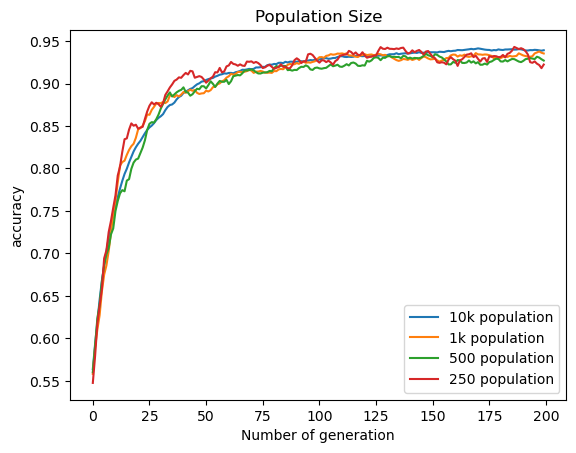

In [89]:
plt.plot(pop_10k, label="10k population")
plt.plot(pop_1k, label="1k population")
plt.plot(pop_500, label="500 population")
plt.plot(pop_250, label="250 population")
plt.legend()
plt.xlabel("Number of generation")
plt.ylabel("accuracy")
plt.title("Population Size")
plt.show()

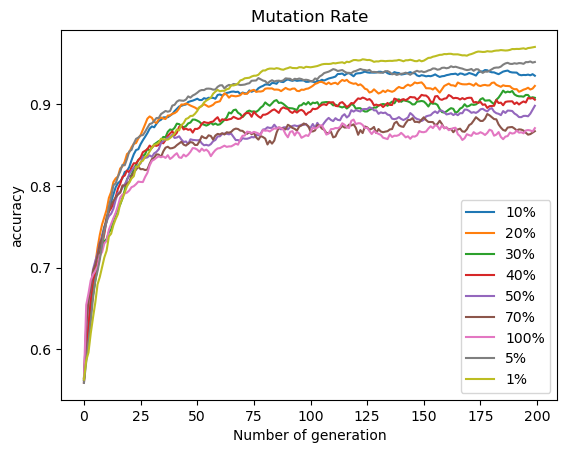

In [88]:
plt.plot(mut_10, label="10%")
plt.plot(mut_20,label="20%")
plt.plot(mut_30,label="30%")
plt.plot(mut_40,label="40%")
plt.plot(mut_50,label="50%")
plt.plot(mut_70,label="70%")
plt.plot(mut_100,label="100%")
plt.plot(mut_5,label="5%")
plt.plot(mut_1,label="1%")
plt.legend()
plt.xlabel("Number of generation")
plt.ylabel("accuracy")
plt.title("Mutation Rate")
plt.show()


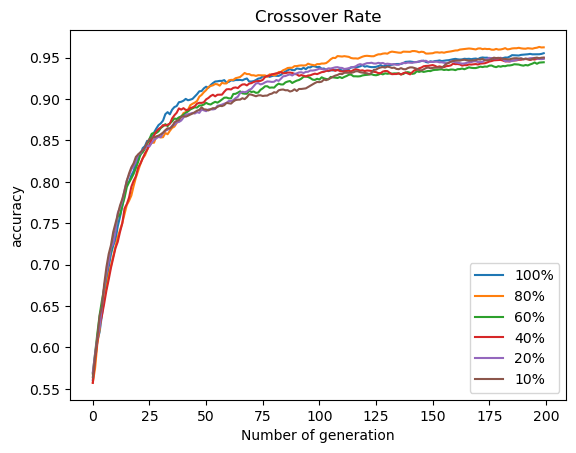

In [105]:
plt.plot(cor_100, label="100%")
plt.plot(cor_80,label="80%")
plt.plot(cor_60,label="60%")
plt.plot(cor_40,label="40%")
plt.plot(cor_20,label="20%")
plt.plot(cor_10,label="10%")
plt.legend()
plt.xlabel("Number of generation")
plt.ylabel("accuracy")
plt.title("Crossover Rate")
plt.show()

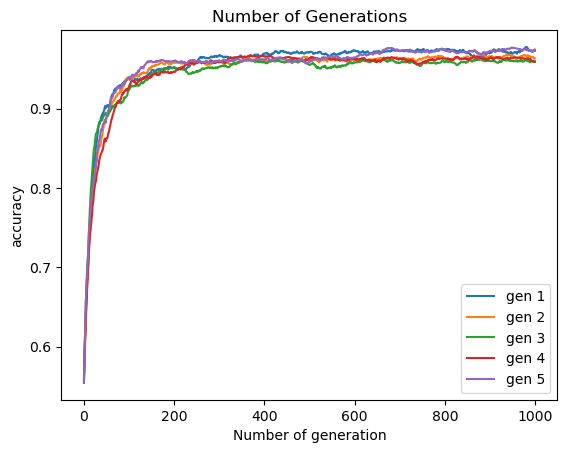

In [121]:
plt.plot(gen_1,label="gen 1")
plt.plot(gen_2,label="gen 2")
plt.plot(gen_3,label="gen 3")
plt.plot(gen_4,label="gen 4")
plt.plot(gen_5,label="gen 5")
plt.legend()
plt.xlabel("Number of generation")
plt.ylabel("accuracy")
plt.title("Number of Generations")
plt.show()


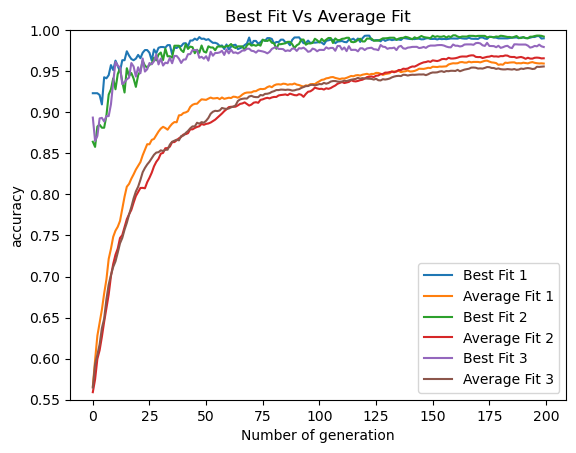

In [146]:
bestfit3=fit_plot
avgfit3=avgfit_plot

plt.plot(bestfit1,label="Best Fit 1")
plt.plot(avgfit1,label="Average Fit 1")
plt.plot(bestfit2,label="Best Fit 2")
plt.plot(avgfit2,label="Average Fit 2")
plt.plot(bestfit3,label="Best Fit 3")
plt.plot(avgfit3,label="Average Fit 3")
plt.legend()
plt.xlabel("Number of generation")
plt.ylabel("accuracy")
plt.title("Best Fit Vs Average Fit")
plt.ylim([0.55, 1])
plt.show()

In [46]:
#Checking the reason of why fitness starts so high
# 
import numpy as np

population_size = 1000   # Number of individuals in each generation
# population
population = np.random.randint(0, 101, (population_size, num_variables))

# Initialise population. Randomising different solutions 
solution = np.random.rand(1,6)*100

def calculate_fitness(population, solution):
    difference = 100 - np.abs(solution - population)
    fitness = np.sum(difference, axis=1) / (100 * population.shape[1])
    return fitness

fitness = calculate_fitness(population, solution)
avg_fit = np.mean(fitness)
print("avg_fit:",avg_fit)


avg_fit: 0.6463090822991214


In [12]:
import numpy as np

population_size = 1

no_pulses_1 = np.random.randint(1, 1001, (population_size, 1))
f_0_1 = np.full((population_size,1),250E6)
amplitude_1 = np.random.uniform(0.1, 0.21, (population_size, 1))
freq_sweep_1 = np.full((population_size,1),12E6/4)
duration_1 = np.random.uniform(10E-6, 500E-6, (population_size, 1))
delay_1 = np.random.uniform(50E-6, 500E-6, (population_size, 1))
#tau = np.random.uniform(0.5E-6, 500E-6, (population_size, 1))
phase_1 = np.zeros((population_size,1))

population1 = np.hstack((no_pulses_1, f_0_1, amplitude_1, freq_sweep_1, duration_1, delay_1, phase_1))

no_pulses_2 = np.random.randint(1, 1001, (population_size, 1))
f_0_2 = np.full((population_size,1),250E6)
amplitude_2 = np.random.uniform(0.1, 0.21, (population_size, 1))
freq_sweep_2 = np.full((population_size,1),12E6/4)
duration_2 = np.random.uniform(10E-6, 500E-6, (population_size, 1))
delay_2 = np.random.uniform(50E-6, 500E-6, (population_size, 1))
#tau = np.random.uniform(0.5E-6, 500E-6, (population_size, 1))
phase_2 = np.zeros((population_size,1))

population2 = np.hstack((no_pulses_2, f_0_2, amplitude_2, freq_sweep_2, duration_2, delay_2, phase_2))

population = np.hstack((population1,population2))

burn = [{'no_pulses': row[0], 'f_0': row[1], 'amplitude': row[2], 'freq_sweep': row[3], 'duration': row[4], 'delay': row[5], 'phase': row[6]} for row in population1]

clean = [{'no_pulses_2': row[0], 'f_0_2': row[1], 'amplitude_2': row[2], 'freq_sweep_2': row[3], 'duration_2': row[4], 'delay_2': row[5], 'phase_2': row[6]} for row in population2]

print('pop1:', burn)
print('pop2:', clean)
print(population)

pop1: [{'no_pulses': np.float64(860.0), 'f_0': np.float64(250000000.0), 'amplitude': np.float64(0.17219299345213923), 'freq_sweep': np.float64(3000000.0), 'duration': np.float64(0.00020277878682840584), 'delay': np.float64(8.985845316251343e-05), 'phase': np.float64(0.0)}]
pop2: [{'no_pulses_2': np.float64(721.0), 'f_0_2': np.float64(250000000.0), 'amplitude_2': np.float64(0.18972141792760416), 'freq_sweep_2': np.float64(3000000.0), 'duration_2': np.float64(0.00013461553987312018), 'delay_2': np.float64(0.00029876405710292485), 'phase_2': np.float64(0.0)}]
[[8.60000000e+02 2.50000000e+08 1.72192993e-01 3.00000000e+06
  2.02778787e-04 8.98584532e-05 0.00000000e+00 7.21000000e+02
  2.50000000e+08 1.89721418e-01 3.00000000e+06 1.34615540e-04
  2.98764057e-04 0.00000000e+00]]


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('signature.mplstyle')

# Parent directory to import the functions package
#sys.path.append(os.path.join(os.path.dirname(__file__), '..')) # for .py
parent_directory = os.path.abspath('..')                        #for .ipynb
sys.path.append(parent_directory)                               # for .ipynb

from measurements.functions.GA_functions import fitness_pit, select, crossover, mutate  # Importing the functions 

# Defining the path to the folder containing the echo data CSV files. Used for fitness function
#echo_data_folder = os.path.join(os.path.dirname(__file__), '..', 'echo_data') # for .py

# Define parameters for GA
population_size = 20                             # Number of individuals in each generation
num_parents = 10                               # Number of parents selected to breed (50% usually good)
num_generations = 5                              # Number of generations
crossover_rate = 0.8                               # Probability of crossover
mutation_rate = 0.01                               # Probability of mutation
mutation_range = [1, 5E5, 0.01, 1E-7, 5E-7, 5E-7, 0]  # Range of mutation 
fixed_val = [1,3,6]
# DO NOT CHANGE
num_variables = 7                                                  # Number of parameters to optimize
lower_bounds = [1, 10E5, 0.001, 200E6, 10E-6, 10E-6, 0]              # Bounds on parameters
upper_bounds = [1001, 500E6, 0.21, 300E6, 100E-6, 300E-6, 0]            # Bounds on parameters

# Creation of population pit
no_pulses_1 = np.random.randint(1, 1001, (population_size, 1))
f_0_1 = np.full((population_size,1),250E6)
amplitude_1 = np.random.uniform(0.1, 0.21, (population_size, 1))
freq_sweep_1 = np.full((population_size,1),12E6/4)  #17e6
duration_1 = np.random.uniform(10E-6, 500E-6, (population_size, 1))
delay_1 = np.random.uniform(50E-6, 500E-6, (population_size, 1))
#tau = np.random.uniform(0.5E-6, 500E-6, (population_size, 1))
phase = np.zeros((population_size,1))

population1 = np.hstack((no_pulses, f_0, amplitude, freq_sweep, duration, delay, phase))
# Converting into dictionary 
population_1 = [{'no_pulses_1': row[0], 'f_0_1': row[1], 'amplitude_1': row[2], 'freq_sweep_1': row[3], 'duration_1': row[4], 'delay_1': row[5], 'phase_1': row[6]} for row in population1]



# print(population)
fitness = np.zeros((population_size,num_generations+1))

for j in range(num_generations):
    # fitness = np.zeros((population_size,1))
    os.mkdir(save_path + f'gen_{j}/')
    instr.path = save_path + f'gen_{j}/'
    for i in range(population_size):

        sequence_params['pit_params'] = population_1[i]
        # compile and upload to HDAWG
        awg_program = dat.read_HDAWG_file(sequence, sequence_params)
        awgMod.compile(device, awg_program)
        # Run HDAWG Sequence
        awgMod.run_sequence(device, single=0)

        sleep(1)

        name = f'echo_{i}'
        echo_data_folder = save_path + f'gen_{j}/' + name                                                 # for .ipynb

        dat.write_json(save_path + f'gen_{j}/' + name + '.json',sequence_params)
        instr.fname = f'{name}'
        instr.save = True
        instr.acquire(mode='AVER', N=5, auto=False, length=4E6)

        sleep(1)

        fitness[i,j] = fitness_pit(echo_data_folder)
    
    # plt.Figure()
    # plt.plot(fitness,label=f'{j}')

    parents = select(population, num_parents, fitness[:,j])

    population = crossover(parents, crossover_rate, population_size)
    population = mutate(population, mutation_rate, mutation_range, lower_bounds, upper_bounds, fixed_val)
    population2 = [{'no_pulses': row[0], 'f_0': row[1], 'amplitude': row[2], 'freq_sweep': row[3], 'duration': row[4], 'delay': row[5], 'phase': row[6]} for row in population]



#Finding the best pit out of all the generations
best_sol = population[np.argmax(fitness), :]
pit_final = [{'no_pulses': row[0], 'f_0': row[1], 'amplitude': row[2], 'freq_sweep': row[3], 'duration': row[4], 'delay': row[5], 'phase': row[6]} for row in best_sol]


# plt.legend()





In [ ]:
# Creation of population burn
no_pulses_2 = np.random.randint(1, 1001, (population_size, 1))
f_0_2 = np.full((population_size,1),250E6)
amplitude_2 = np.random.uniform(0.1, 0.21, (population_size, 1))
freq_sweep_2 = np.full((population_size,1),12E6/4)
duration_2 = np.random.uniform(10E-6, 500E-6, (population_size, 1))
delay_2 = np.random.uniform(50E-6, 500E-6, (population_size, 1))
phase_2 = np.zeros((population_size,1))

population_2 = np.hstack((no_pulses_2, f_0_2, amplitude_2, freq_sweep_2, duration_2, delay_2, phase_2))
# Converting into dictionary 
population_burn = [{'no_pulses': row[0], 'f_0': row[1], 'amplitude': row[2], 'freq_sweep': row[3], 'duration': row[4], 'delay': row[5], 'phase': row[6]} for row in population2]

# Creation of population clean
no_pulses_3 = np.random.randint(1, 1001, (population_size, 1))
f_0_3 = np.full((population_size,1),250E6)
amplitude_3 = np.random.uniform(0.1, 0.21, (population_size, 1))
freq_sweep_3 = np.full((population_size,1),12E6/4)
duration_3 = np.random.uniform(10E-6, 500E-6, (population_size, 1))
delay_3 = np.random.uniform(50E-6, 500E-6, (population_size, 1))
phase_3 = np.zeros((population_size,1))

population_3 = np.hstack((no_pulses_3, f_0_3, amplitude_3, freq_sweep_3, duration_3, delay_3, phase_3))
# Converting into dictionary 
population_clean = [{'no_pulses_3': row[0], 'f_0_3': row[1], 'amplitude_3': row[2], 'freq_sweep_3': row[3], 'duration_3': row[4], 'delay_3': row[5], 'phase_3': row[6]} for row in population3]

## Burn And Clean array
population_burn_clean = np.hstack((population_burn,population_clean))



for j in range(num_generations):

    for i in range(population_size):

        fitness[i,j] = fitness_pit(echo_data_folder)
    
    parents = select(population, num_parents, fitness[:,j])

    population_burn_clean = crossover(parents, crossover_rate, population_size)
    population_burn_clean = mutate(population, mutation_rate, mutation_range, lower_bounds, upper_bounds, fixed_val)
    population_burn = [{'no_pulses': row[0], 'f_0': row[1], 'amplitude': row[2], 'freq_sweep': row[3], 'duration': row[4], 'delay': row[5], 'phase': row[6]} for row in population_burn_clean]
    population_clean = [{'no_pulses': row[7], 'f_0': row[8], 'amplitude': row[9], 'freq_sweep': row[10], 'duration': row[11], 'delay': row[12], 'phase': row[13]} for row in population_burn_clean]





In [42]:
import numpy as np
pop = np.zeros((3,2,2))

for ii in range(5):
    population_size = np.array([20, 50, 100 ,200, 500])
    num_parents = population_size/2
    print(f'run_{ii}_pop_{population_size[ii]}')
    for j in range(2):
        pop[ii,j,:] = np.random.randint(0, 10, size=(1,2))

pop_save = np.random.randint(0, 10, size=(3, 2, 2))
fit=np.random.randint(0, 10, size=(2, 2))
max_index = np.unravel_index(np.argmax(fit), fit.shape)
print('pop',pop_save)
print('fit',fit)
print(max_index)
best_sol = pop_save[max_index]
print(best_sol)

pop_save[j, i,:] = population


run_0_pop_20
run_1_pop_50
run_2_pop_100
run_3_pop_200


IndexError: index 3 is out of bounds for axis 0 with size 3